In [1]:
import fitting_functions as fitting 
from spacetime_plot import plot_fitbounds, plot_fit
from edes.modules.detection.detection_utils import plot, plot_ax, plot_errbar
import numpy as np 
import matplotlib.pyplot as plt 
import h5py
import os
from scipy.special import gammainc

In [2]:
result_base = '/home/electron/'
plt.rcParams.update({'font.size': 14,
                     'lines.markersize': 12,
                     'lines.linewidth': 2.5,
                     'xtick.labelsize': 15,
                     'ytick.labelsize': 15,
                     'errorbar.capsize': 2})

In [5]:
def read_h5(result_path, xname, yname, print_name=False):
    file_path = f'{result_base}/{result_path}'
    with h5py.File(file_path, 'r') as file:
        dataset_names = list(file['datasets'].keys())
        data_dict = {name: np.array(file['datasets'][name][()]) for name in dataset_names}
        if print_name: 
            print(data_dict)
    return np.array(data_dict[xname]), np.array(data_dict[yname])

class double_exponential(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['A', r'$\tau_1$', 'B', r'$\tau_2$']
        self.setup()
        self.eq_str = r'$y=A e^{-t/\tau_1} + B e^{-t/\tau_2}$'

    def full_fun(self, t, A, t1, B, t2):
        return A*np.exp(-t/t1) + B*np.exp(-t/t2)

class exponential_saturate(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['A', r'$\tau$']
        self.setup()
        self.eq_str = r'$y=A(1-e^{-t/\tau})$'

    def full_fun(self, t, A, t1):
        return A*(1-np.exp(-t/t1))

class sigmoid_saturate(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['A', 'B', r'C', r'$\tau$']
        self.setup()
        self.eq_str = r'$y=\frac{A}{1+Be^{-t/\tau}}+C$'

    def full_fun(self, t, A, B, C, t1):
        return A/(1+B*np.exp(-t/t1))+C

class dexponential_saturate(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['A', r'$\tau_1$', 'B', r'$\tau_2$', 'C']
        self.setup()
        self.eq_str = r'$y=A e^{-t/\tau_1} + B e^{-t/\tau_2}$ + C'

    def full_fun(self, t, A, t1, B, t2, C):
        return A*np.exp(-t/t1) + B*np.exp(-t/t2) + C

class pexponential_saturate(fitting.fitting_function):
    def __init__(self):
        self.parameters = [r'$\tau$', 'N']
        self.setup()
        self.eq_str = r'CDF of Poisson with $P(n \geq N)$'

    def full_fun(self, t, t1, N):
        return gammainc(N, t/t1)


class U2_fit(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['A', '$\omega_0$']
        self.setup()
        self.eq_str = r'$\omega_z=\sqrt{AU_2+\omega_0^2}$'

    def full_fun(self, t, A, B):
        return A*t+B**2

def plot_fitbounds(xdata,ydata,xfit,yfit,yT,yB,fit_params_dict,
                   xlabel=None, ylabel=None, xlim=None, fit_label='',
                   ylim=None, title=None, title_append=None, sigfigs=3, 
                   logx=False, logy=False):
    (fig, ax) = plt.subplots(figsize=(8, 5))

    fit_label = f'Fit {fit_label}\n'
    for key, value in fit_params_dict.items():
        fit_label += '{0} = {1:.{3}g} $\pm$ {2:.1g}\n'.format(key, value[0], value[1], sigfigs)
    fit_label = fit_label[:-1]
    
    ax.plot(xfit, yfit, color='k', label=fit_label)
    ax.plot(xdata, ydata, 'r.', markersize=12)
    ax.fill_between(xfit, yB, yT)
    if title_append is not None:
        title += title_append
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=12)
    if logx: 
        ax.set_xscale('log') 
    if logy: 
        ax.set_yscale('log')
    plt.show()

def plot_fitbounds_ax(ax, xdata,ydata,xfit,yfit,yT,yB,fit_params_dict,*args,
                   xlabel=None, ylabel=None, xlim=None, fit_label='',
                   ylim=None, title=None, title_append=None, sigfigs=3, 
                   logx=False, logy=False, **kwargs):
    fit_label = f'{fit_label}\n'
    for key, value in fit_params_dict.items():
        fit_label += '{0} = {1:.{3}g} $\pm$ {2:.1g}\n'.format(key, value[0], value[1], sigfigs)
    fit_label = fit_label[:-1]
    
    line = ax.plot(xdata, ydata, '.', markersize=13, *args, **kwargs)
    ax.plot(xfit, yfit, '--', *args, alpha=0.8, c=line[0].get_color(), label=fit_label, **kwargs)
    ax.fill_between(xfit, yB, yT, *args, alpha=0.4, **kwargs)
    if title_append is not None:
        title += title_append
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_title(title)
    ax.grid(True)
    ax.legend(fontsize=12)
    if logx: 
        ax.set_xscale('log') 
    if logy: 
        ax.set_yscale('log')

def plot_lifetime(file_name): 
    t_wait, counts = read_h5(file_name, 'count_lifetime_x', 'count_lifetime')
    dexp_fit = double_exponential() 

    guess_params = {r'$\tau_1$': 5,
                    'A': 300,
                    'B': 100,
                    r'$\tau_2$': 10
                    # 'startfrom2': 100,
                    # 'decayto2': 20
                    }
    dexp_fit.set_guess_params(guess_params)
    dexp_fit.do_fit(t_wait/1000, counts)
    xfit = np.linspace(min(t_wait/1000), max(t_wait/1000), 1000)
    yfit = dexp_fit.eval_with_fits(xfit)
    yT,yB = dexp_fit.eval_with_bounds(xfit)
    dexp_fit.get_fits()
    plot_fitbounds(t_wait/1000, counts, xfit, yfit, yT,yB,dexp_fit.get_fits(), logx=True,
                   xlabel=r'$t_{\rm{wait}}$ (ms)', ylabel='Counts', fit_label=dexp_fit.eq_str)

def plot_loading(file_name, rep=5000): 
    t_wait, counts = read_h5(file_name, 'count_load_x', 'count_load')
    prob = counts/rep
    #dexp_fit = sigmoid_saturate() 
    dexp_fit = pexponential_saturate() 
    # guess_params = {r'$\tau$': 5,
    #                 'C': 0,
    #                 'A': 1, 
    #                 'B': 1
    #                 }
    guess_params = {r'$\tau$': 0.3, 
                    'N': 1
                    }
    dexp_fit.set_guess_params(guess_params)
    dexp_fit.do_fit(t_wait/1000, prob)
    xfit = np.linspace(min(t_wait/1000), max(t_wait/1000), 1000)
    yfit = dexp_fit.eval_with_fits(xfit)
    yT,yB = dexp_fit.eval_with_bounds(xfit)
    dexp_fit.get_fits()
    plot_fitbounds(t_wait/1000, prob, xfit, yfit, yT,yB,dexp_fit.get_fits(),
                   xlabel=r'$t_{\rm{load}}$ (ms)', ylabel='Detection Probability', fit_label=dexp_fit.eq_str)

def plot_lifetime_set(all_lifetimes, fit_labels, rep=5000, show_fill=False, sigfigs=3, legend_anchor=(0.53,1)):
    fig, ax = plt.subplots(figsize=(8,6))
    for i in range(len(all_lifetimes)): 
        lifetime, fit_label = all_lifetimes[i], fit_labels[i]
        t_wait, counts = read_h5(lifetime, 'count_lifetime_x', 'count_lifetime')
        prob = counts/rep
        dexp_fit = double_exponential() 
    
        guess_params = {r'$\tau_1$': 5,
                        'A': 300,
                        'B': 100,
                        r'$\tau_2$': 10
                        # 'startfrom2': 100,
                        # 'decayto2': 20
                        }
        dexp_fit.set_guess_params(guess_params)
        dexp_fit.do_fit(t_wait/1000, prob)
        xfit = np.linspace(min(t_wait/1000), max(t_wait/1000), 1000)
        yfit = dexp_fit.eval_with_fits(xfit)
        yT,yB = dexp_fit.eval_with_bounds(xfit)
        dexp_fit.get_fits()
        
        fit_params_dict = dexp_fit.get_fits()
        fit_label = f'{fit_label}, '
        for key, value in fit_params_dict.items():
            if 'tau' in key:
                fit_label += '{0} = {1:.{3}g} $\pm$ {2:.1g}, '.format(key, value[0], value[1], sigfigs)
        fit_label = fit_label[:-1]
        
        line = ax.plot(t_wait/1000, prob, '.', markersize=13)
        ax.plot(xfit, yfit, '--', alpha=0.8, c=line[0].get_color(), label=fit_label)
        if show_fill: 
            ax.fill_between(xfit, yB, yT, alpha=0.4)
        ax.set_xlabel(r'$t_{\rm{wait}}$ (ms)', fontsize=14)
        ax.set_ylabel('Detection Probability', fontsize=14)
        ax.grid(True)
        ax.set_xscale('log') 
        # if logy: 
        #     ax.set_yscale('log')
        ax.legend(fontsize=12, bbox_to_anchor=legend_anchor)
    plt.show()

def plot_ax_errbar(ax, x, y, yerr, *args, xerr=None, xlabel=None, ylabel=None, title=None, **kwargs):
    ax.errorbar(x, y, yerr, xerr=xerr, *args, **kwargs)
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def plot_lifetime_N_scale(all_lifetimes, rep=5000):
    fig, ax = plt.subplots(figsize=(8,6))
    all_det_prob = [] 
    all_det_prob_err = []
    all_tau1 = [] 
    all_tau1_err = [] 
    all_tau2 = [] 
    all_tau2_err = [] 
    
    for i in range(len(all_lifetimes)): 
        lifetime, fit_label = all_lifetimes[i], fit_labels[i]
        t_wait, counts = read_h5(lifetime, 'count_lifetime_x', 'count_lifetime')
        prob = counts/rep
        dexp_fit = double_exponential() 
    
        guess_params = {r'$\tau_1$': 5,
                        'A': 300,
                        'B': 100,
                        r'$\tau_2$': 10
                        # 'startfrom2': 100,
                        # 'decayto2': 20
                        }
        dexp_fit.set_guess_params(guess_params)
        dexp_fit.do_fit(t_wait/1000, prob)
        xfit = np.linspace(min(t_wait/1000), max(t_wait/1000), 1000)
        yfit = dexp_fit.eval_with_fits(xfit)
        yT,yB = dexp_fit.eval_with_bounds(xfit)
        dexp_fit.get_fits()
        
        fit_params_dict = dexp_fit.get_fits()
        tau = []
        max_det_prob = yfit[0]
        all_det_prob.append(max_det_prob)
        all_det_prob_err.append(abs(yT[0]-yB[0]))
        for key, value in fit_params_dict.items():
            if 'tau' in key:
                tau.append((value[0], value[1]))
        tau.sort(key=lambda x: x[0])
        all_tau1.append(tau[0][0])
        all_tau1_err.append(tau[0][1])
        all_tau2.append(tau[1][0])
        all_tau2_err.append(tau[1][1])
        
    plot_ax_errbar(ax, all_det_prob, all_tau1, all_tau1_err, xerr=all_det_prob_err, fmt='o--', markersize=8, label=r'$\tau_1$')
    plot_ax_errbar(ax, all_det_prob, all_tau2, all_tau2_err, xerr=all_det_prob_err, fmt='o--', markersize=8, label=r'$\tau_2$')
    ax.set_xlabel('Maximum detection probability')
    ax.set_ylabel('Lifetime (ms)')
    ax.legend()
    ax.set_yscale('log')
    plt.show()

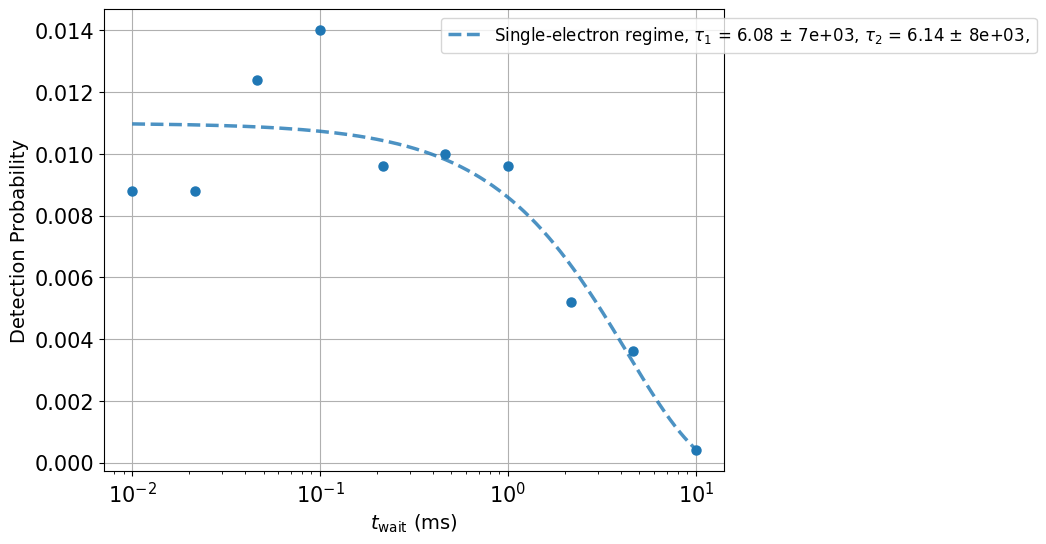

In [9]:
all_lifetimes = ['artiq/experiment/artiq-master/results/2025-09-11/19/000008086-lifetime_experiment.h5'
                 ]
fit_labels = ['Single-electron regime']
plot_lifetime_set(all_lifetimes, fit_labels, rep=2500, show_fill=False)

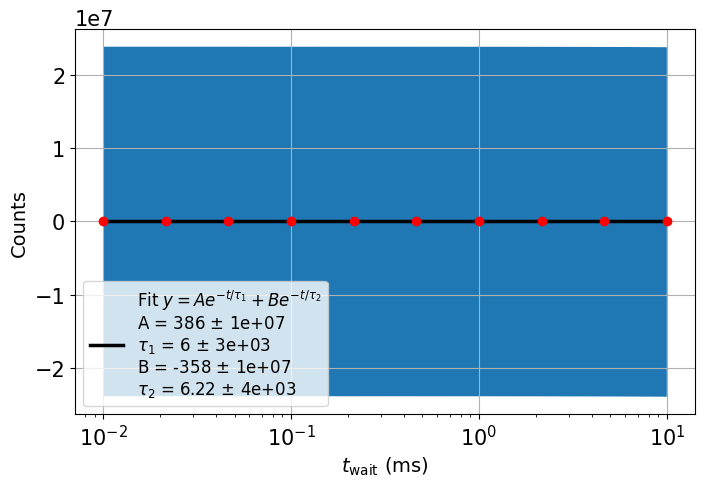

In [4]:
plot_lifetime('artiq/experiment/artiq-master/results/2025-09-11/19/000008086-lifetime_experiment.h5')

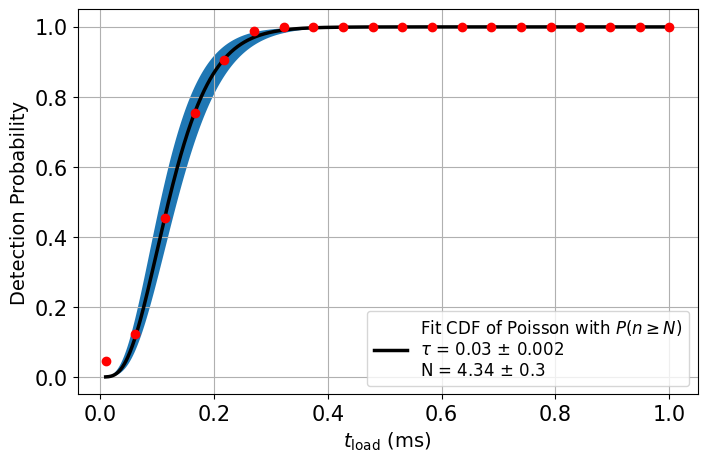

In [10]:
plot_loading('artiq/experiment/artiq-master/results/2025-09-04/16/000007944-loading_experiment.h5')

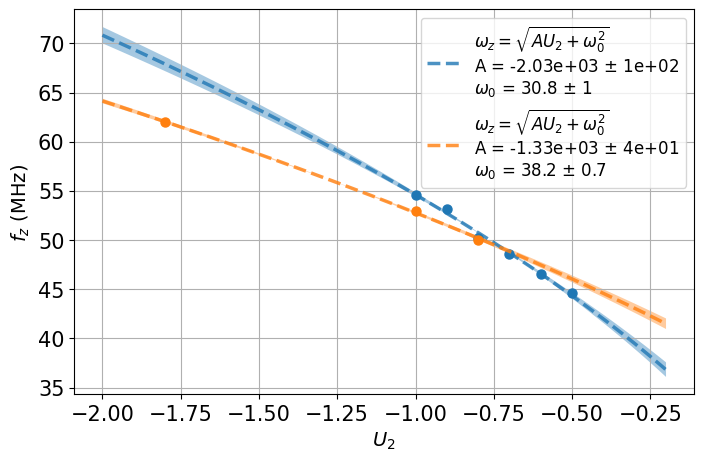

In [137]:
fig, ax = plt.subplots(figsize=(8,5))
fz = np.array([54.6, 53.2, 50.2, 48.6, 46.5, 44.6])
U2 = np.array([-1, -0.9, -0.8, -0.7, -0.6, -0.5])
quad = U2_fit() 

guess_params = {"$\omega_0$": 20,
                'A': -2500
                # 'startfrom2': 100,
                # 'decayto2': 20
                }
quad.set_guess_params(guess_params)
quad.do_fit(U2, fz**2)
xfit = np.linspace(-2, -0.2, 200)
yfit = quad.eval_with_fits(xfit)
yT,yB = quad.eval_with_bounds(xfit)
quad.get_fits()
plot_fitbounds_ax(ax, U2, fz, xfit, np.sqrt(yfit), np.sqrt(yT),np.sqrt(yB),quad.get_fits(),
               xlabel=r'$U_2$', ylabel=r'$f_z$ (MHz)', fit_label=quad.eq_str)

fz = np.array([50, 53, 62])
U2 = np.array([-0.8, -1, -1.8])
quad = U2_fit() 

guess_params = {"$\omega_0$": 20,
                'A': -2500
                # 'startfrom2': 100,
                # 'decayto2': 20
                }
quad.set_guess_params(guess_params)
quad.do_fit(U2, fz**2)
xfit = np.linspace(-2, -0.2, 200)
yfit = quad.eval_with_fits(xfit)
yT,yB = quad.eval_with_bounds(xfit)
quad.get_fits()
plot_fitbounds_ax(ax, U2, fz, xfit, np.sqrt(yfit), np.sqrt(yT),np.sqrt(yB),quad.get_fits(),
               xlabel=r'$U_2$', ylabel=r'$f_z$ (MHz)', fit_label=quad.eq_str)

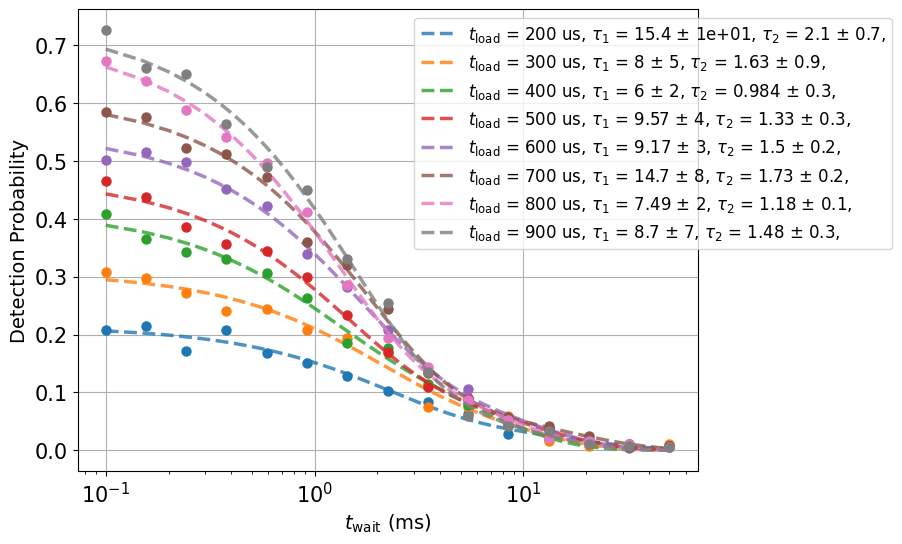

In [168]:
all_lifetimes = ['artiq-nix/electron/artiq-master/results/2025-03-24/18/000007019-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007020-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007021-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007022-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007023-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007024-lifetime_experiment.h5', 
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007025-lifetime_experiment.h5',
                 'artiq-nix/electron/artiq-master/results/2025-03-24/19/000007026-lifetime_experiment.h5'
                 ]
fit_labels = [r'$t_{\rm{load}}$' + f' = {i} us' for i in range(200, 1000, 100)]
plot_lifetime_set(all_lifetimes, fit_labels, rep=500, show_fill=False)

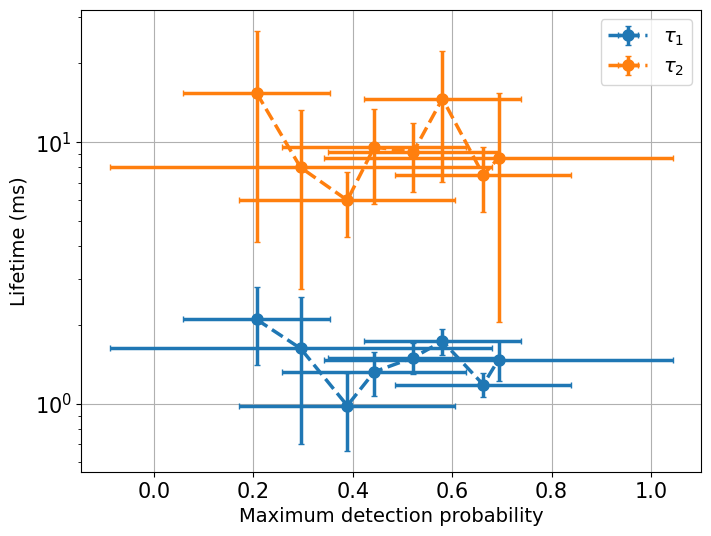

In [167]:
plot_lifetime_N_scale(all_lifetimes, rep=500)